In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas
import datetime
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def pred_bin_out(row, nBins, binTimeRes):
    """
    Given the prediction label, get the actual
    output in bins by converting the label into
    binary representation. For ex, label 2 would
    convert to 10 and 5 to 101 and so on.
    """
    # Note we need the binary format to be consistent
    # with the actual labels, i.e., it depends on the 
    # number of bins. For example, 2 could be 10 or 010.
    binFormtStr = '{0:0' + str(nBins) + 'b}'
    predBinStr = binFormtStr.format(row["pred_label"])
    # Now add these into different pred bins
    for _n, _pb in enumerate(predBinStr):
        row["pbin_" + str(_n)] = int(_pb)
    if row["label"] == 0:
        if row["pred_label"] == 0:
            predType = "TN"
        else:
            predType = "FP"
    if row["label"] == 1:
        if row["pred_label"] == 1:
            predType = "TP"
        else:
            predType = "FN"
    row["pred_type"] = predType
    return row

In [3]:
colNames = ["date"]
nBins = 1
binRes = 90
for _nb in range(nBins):
    colNames += [ "bin_" + str(_nb) ]
# colNames += ["label", "pred_label"]
# colNames += [ "label", "del_sml","del_sme","min_sml","max_sme","pred_label" ]
colNames += ["label", "del_minutes","pred_label"]
for _nb in range(nBins):
    # there are 2 probs for each bin
    # one zero prob and other 1 prob
    colNames += [ "prob_type_0_b_" + str(_nb) ]
    colNames += [ "prob_type_1_b_" + str(_nb) ]
print colNames
predDF = pandas.read_csv("../data/resnet_test_data_pred.csv", names=colNames,\
                     header=0, parse_dates=["date"])
predDF = predDF.apply( pred_bin_out, args=(nBins,binRes,),\
                      axis=1 )
predDF.head()

['date', 'bin_0', 'label', 'del_minutes', 'pred_label', 'prob_type_0_b_0', 'prob_type_1_b_0']


,date,bin_0,label,del_minutes,pred_label,prob_type_0_b_0,prob_type_1_b_0,pbin_0,pred_type
0,2015-01-27 22:50:00,1,1,29.0,1,0.316822,0.683178,1,TP
1,2015-01-27 22:55:00,1,1,24.0,1,0.323714,0.676286,1,TP
2,2015-01-27 23:00:00,1,1,19.0,1,0.348204,0.651796,1,TP
3,2015-01-27 23:05:00,1,1,14.0,1,0.350489,0.649511,1,TP
4,2015-01-27 23:10:00,1,1,9.0,1,0.329317,0.670683,1,TP


In [4]:
start_date = predDF["date"].min() - datetime.timedelta(hours=2)
end_date = predDF["date"].max()
print start_date, end_date

2015-01-27 20:50:00 2017-12-31 23:55:00


In [5]:
omn_dbdir = "../data/sqlite3/"
omn_db_name = "smu_sml_sme.sqlite"
omn_table_name = "smusmlsme"

In [6]:
# read omni data
conn = sqlite3.connect(omn_dbdir + omn_db_name,
                       detect_types = sqlite3.PARSE_DECLTYPES)
# load data to a dataframe
command = "SELECT datetime, al, ae, au FROM {tb} WHERE datetime BETWEEN '{stm}' and '{etm}'"
command = command.format(tb=omn_table_name,\
                         stm=start_date, etm=end_date)
smlDF = pandas.read_sql(command, conn)
# drop nan's
smlDF.dropna(inplace=True)
smlDF.head()

,datetime,al,ae,au
0,2015-01-27 20:50:00,-250,433,183
1,2015-01-27 20:51:00,-248,430,182
2,2015-01-27 20:52:00,-253,439,186
3,2015-01-27 20:53:00,-258,443,185
4,2015-01-27 20:54:00,-262,452,190


In [7]:
# get the dates from the sel type
# and store the results in a dict!
delTimeList = [ 0.25, 0.5, 1, 2 ]
smlVarDict = {}
for _pt in predDF["pred_type"].unique():
    selDFDates = predDF[ predDF["pred_type"] == _pt ]["date"].tolist()
    # Now we need the time history at each of these dates
    for _dtl in delTimeList:
        allDatesList = []
        for _cd in selDFDates:
#             _ed =_cd + datetime.timedelta(minutes=int(_dtl*60))
            _cdtList = [ _cd + datetime.timedelta(minutes=_x) for _x in range(int(_dtl*60)) ]
            allDatesList += _cdtList
        _resDF = smlDF[ smlDF["datetime"].isin(allDatesList) ]
        _currKey = _pt + str( int(_dtl*60) )
        smlVarDict[_currKey] = _resDF

In [8]:
smlVarDict["TP60"].describe()

,al,ae,au
count,336055.000000,336055.000000,336055.000000
mean,-330.236289,491.785279,161.549910
std,228.936272,306.643537,113.886353
min,-3593.000000,38.000000,10.000000
25%,-445.000000,265.000000,89.000000
50%,-282.000000,423.000000,133.000000
75%,-160.000000,641.000000,199.000000
max,-6.000000,4261.000000,1576.000000


In [9]:
smlVarDict["TN60"].describe()

,al,ae,au
count,753480.000000,753480.000000,753480.000000
mean,-80.936825,160.741379,79.805453
std,68.391567,118.295815,77.255525
min,-1646.000000,24.000000,4.000000
25%,-103.000000,87.000000,41.000000
50%,-59.000000,129.000000,62.000000
75%,-37.000000,194.000000,95.000000
max,-3.000000,3173.000000,2802.000000


In [10]:
smlVarDict["FN60"].describe()

,al,ae,au
count,98740.000000,98740.000000,98740.000000
mean,-179.399818,279.574245,100.174924
std,134.183716,174.799626,69.260454
min,-1327.000000,28.000000,10.000000
25%,-244.000000,155.000000,57.000000
50%,-150.000000,240.000000,85.000000
75%,-77.000000,359.000000,125.000000
max,-6.000000,1566.000000,984.000000


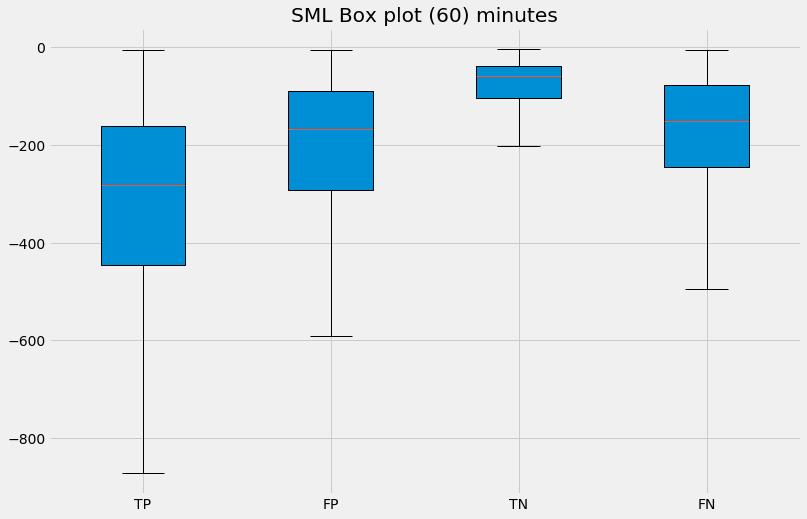

In [11]:
plt.style.use("fivethirtyeight")

histIntSel = 60
plotParamList = [ "TP" + str(histIntSel), "FP" + str(histIntSel),\
                "TN" + str(histIntSel), "FN" + str(histIntSel)]

f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)

coll120Bz = [ smlVarDict[plotParamList[0]]["al"].values,\
             smlVarDict[plotParamList[1]]["al"].values,\
        smlVarDict[plotParamList[2]]["al"].values,\
             smlVarDict[plotParamList[3]]["al"].values]
ax1.boxplot( coll120Bz, patch_artist=True, showfliers=False )

ax1.set_xticklabels(['TP', 'FP', 'TN', 'FN'])

ax1.set_title("SML Box plot (" + str(histIntSel) + ") minutes")

f.savefig("../plots/categorical_sml_box.pdf", bbox_inches='tight')

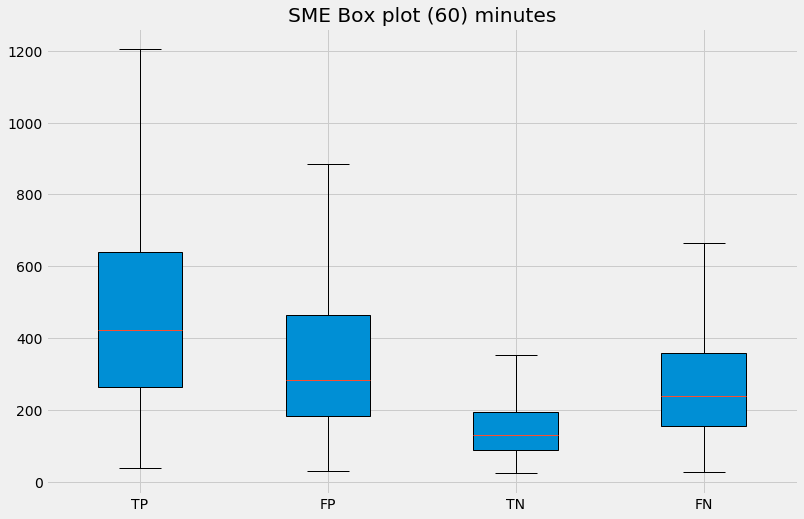

In [12]:
plt.style.use("fivethirtyeight")

histIntSel = 60
plotParamList = [ "TP" + str(histIntSel), "FP" + str(histIntSel),\
                "TN" + str(histIntSel), "FN" + str(histIntSel)]

f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)

coll120Bz = [ smlVarDict[plotParamList[0]]["ae"].values,\
             smlVarDict[plotParamList[1]]["ae"].values,\
        smlVarDict[plotParamList[2]]["ae"].values,\
             smlVarDict[plotParamList[3]]["ae"].values]
ax1.boxplot( coll120Bz, patch_artist=True, showfliers=False )

ax1.set_xticklabels(['TP', 'FP', 'TN', 'FN'])
ax1.set_title("SME Box plot (" + str(histIntSel) + ") minutes")

f.savefig("../plots/categorical_sme_box.pdf", bbox_inches='tight')

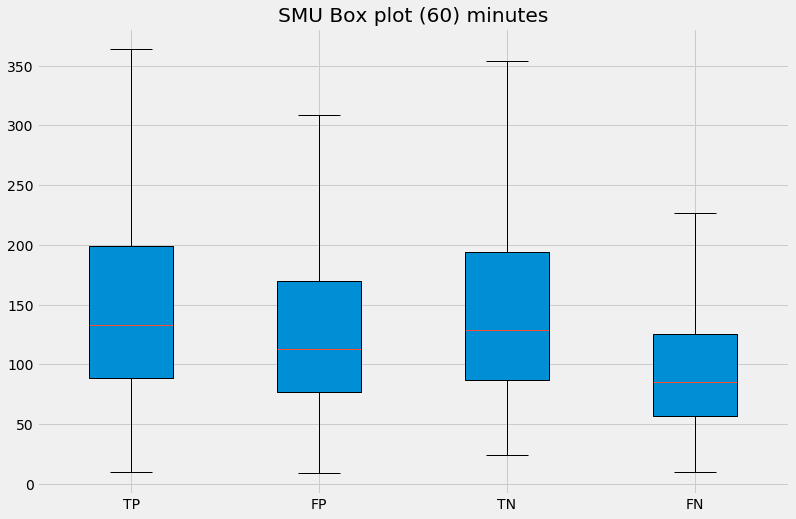

In [13]:
plt.style.use("fivethirtyeight")

histIntSel = 60
plotParamList = [ "TP" + str(histIntSel), "FP" + str(histIntSel),\
                "TN" + str(histIntSel), "FN" + str(histIntSel)]

f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)

coll120Bz = [ smlVarDict[plotParamList[0]]["au"].values,\
             smlVarDict[plotParamList[1]]["au"].values,\
        smlVarDict[plotParamList[2]]["ae"].values,\
             smlVarDict[plotParamList[3]]["au"].values]
ax1.boxplot( coll120Bz, patch_artist=True, showfliers=False )

ax1.set_xticklabels(['TP', 'FP', 'TN', 'FN'])
ax1.set_title("SMU Box plot (" + str(histIntSel) + ") minutes")

f.savefig("../plots/categorical_smu_box.pdf", bbox_inches='tight')